# Support Vector Machine
In this notebook, we investigate the applications of SVMs to music genre classification on the fma-small dataset.

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import sys

sys.path.append('../')

from dependencies import utils

In [2]:
# load the dataset

tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

# select the small dataset

small = tracks['set', 'subset'] <= 'small'

X = features.loc[small]
y = tracks['track', 'genre_top'].loc[small]


In [3]:
# split the small dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# the features are scaled using StandardScaler()

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

c:\Users\jay_w\anaconda3\envs\ecs198G\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jay_w\anaconda3\envs\ecs198G\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jay_w\anaconda3\envs\ecs198G\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [4]:
# function to display the results of each model
def displayResults(model, y_pred):
    print(classification_report(y_test, y_pred))
    cf_mat = confusion_matrix(y_test, y_pred)
    sns.set(rc = {'figure.figsize':(15,10)})

    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
    ax.set_xticklabels(model.classes_)
    kwargs = {'rotation': 'horizontal'}
    ax.set_yticklabels(model.classes_, **kwargs)

    ax.set_title('Confusion Matrix with labels\n\n')

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return None

# ignore all warnings because of data format
import warnings
warnings.filterwarnings("ignore")

## Preliminary tests
We create some baseline models using the linear and polynomial kernel to test that
SVMs can indeed be used to classify tracks in our dataset.

From these results, we can see that the linear kernel shows more promise than the polynomial kernel.

               precision    recall  f1-score   support

   Electronic       0.59      0.61      0.60       194
 Experimental       0.48      0.44      0.46       201
         Folk       0.57      0.64      0.60       206
      Hip-Hop       0.66      0.63      0.65       229
 Instrumental       0.56      0.56      0.56       206
International       0.56      0.67      0.61       176
          Pop       0.40      0.27      0.32       198
         Rock       0.58      0.66      0.61       190

     accuracy                           0.56      1600
    macro avg       0.55      0.56      0.55      1600
 weighted avg       0.55      0.56      0.55      1600



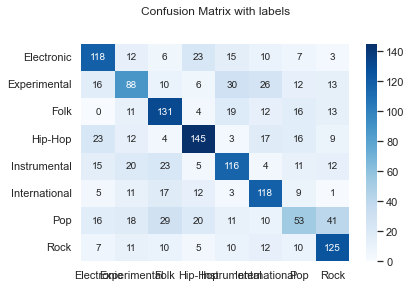

In [5]:
linearSVM = svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False)
y_pred = linearSVM.fit(X=X_train, y=y_train).predict(X_test)

displayResults(linearSVM, y_pred)


               precision    recall  f1-score   support

   Electronic       0.68      0.39      0.50       194
 Experimental       0.70      0.26      0.38       201
         Folk       0.64      0.50      0.56       206
      Hip-Hop       0.61      0.46      0.53       229
 Instrumental       0.64      0.48      0.55       206
International       0.76      0.35      0.48       176
          Pop       0.21      0.75      0.33       198
         Rock       0.62      0.42      0.50       190

     accuracy                           0.45      1600
    macro avg       0.61      0.45      0.48      1600
 weighted avg       0.61      0.45      0.48      1600



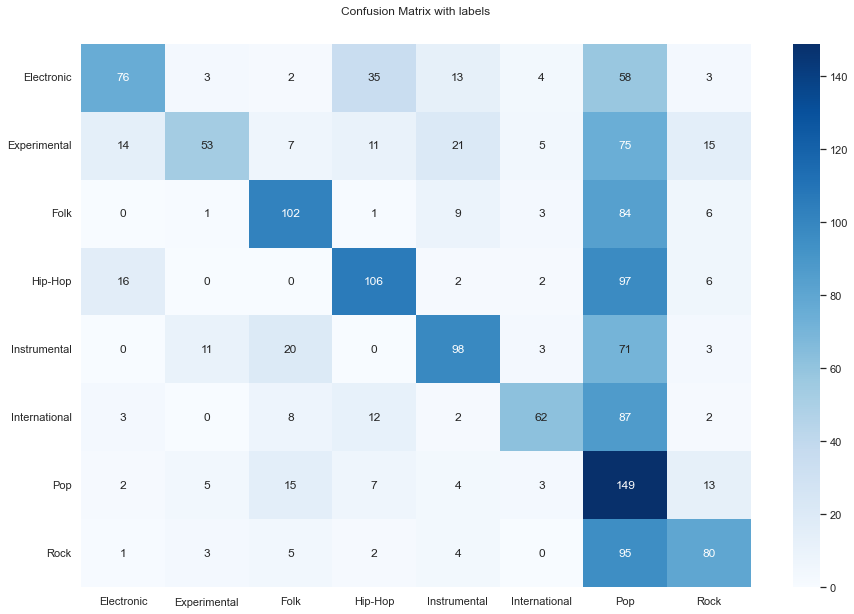

In [6]:
polySVC = svm.SVC(kernel='poly')
y_pred = polySVC.fit(X=X_train, y=y_train).predict(X_test)


displayResults(polySVC, y_pred)

## Kernel Selection
In this section, we use GridSearchCV to test a variety of kernel options for the SVM.

From the grid search results, we see that the rbf kernel performs the best.

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf', 'linear', 'sigmoid'],
    }, {
    'C': [0.1, 1, 10, 100],  
    'degree': [2,3,4,5],
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['poly'],
}]

grid = GridSearchCV(svm.SVC(), param_grid)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


               precision    recall  f1-score   support

   Electronic       0.60      0.64      0.62       194
 Experimental       0.49      0.55      0.52       201
         Folk       0.66      0.69      0.67       206
      Hip-Hop       0.71      0.66      0.68       229
 Instrumental       0.64      0.58      0.61       206
International       0.72      0.75      0.73       176
          Pop       0.50      0.45      0.47       198
         Rock       0.67      0.65      0.66       190

     accuracy                           0.62      1600
    macro avg       0.62      0.62      0.62      1600
 weighted avg       0.62      0.62      0.62      1600



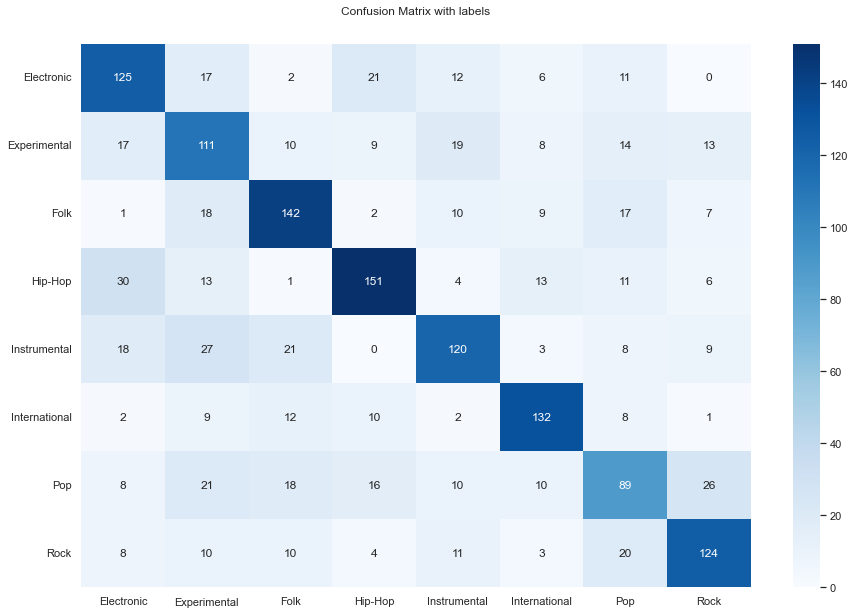

In [8]:
grid_pred = grid.predict(X_test)

displayResults(grid, grid_pred)

## RBF Hyperparameter Optimization
Grid search is used to find the best hyperparameters for the rbf kernel.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 5, 10, 20, 40],  
    'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'], 
    'kernel': ['rbf'],
    }

grid = GridSearchCV(svm.SVC(), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


               precision    recall  f1-score   support

   Electronic       0.60      0.63      0.61       194
 Experimental       0.49      0.57      0.53       201
         Folk       0.68      0.69      0.69       206
      Hip-Hop       0.70      0.65      0.67       229
 Instrumental       0.64      0.62      0.63       206
International       0.74      0.74      0.74       176
          Pop       0.52      0.46      0.49       198
         Rock       0.66      0.66      0.66       190

     accuracy                           0.63      1600
    macro avg       0.63      0.63      0.63      1600
 weighted avg       0.63      0.63      0.63      1600



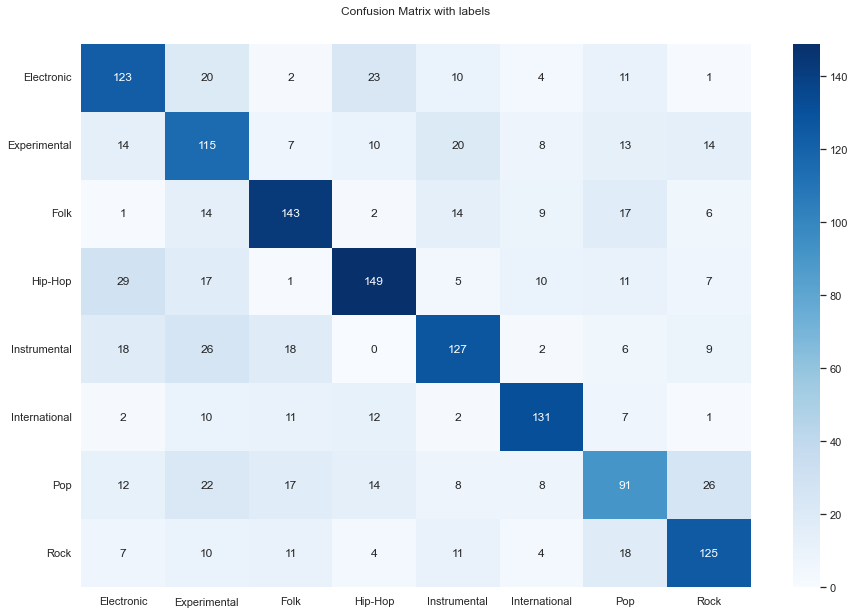

In [11]:
grid_pred = grid.predict(X_test)

displayResults(grid, grid_pred)

## LinearSVC optimization
Grid search is also used to find the optimal hyperparameters for the LinearSVC implemenation of the SVM with linear kernel.

This allows for the use of alternate penalty and loss functions. However, the results are not better than with rbf kernel.

{'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
               precision    recall  f1-score   support

   Electronic       0.59      0.59      0.59       194
 Experimental       0.47      0.44      0.45       201
         Folk       0.57      0.63      0.60       206
      Hip-Hop       0.65      0.63      0.64       229
 Instrumental       0.56      0.56      0.56       206
International       0.55      0.67      0.61       176
          Pop       0.41      0.27      0.32       198
         Rock       0.58      0.66      0.62       190

     accuracy                           0.56      1600
    macro avg       0.55      0.56      0.55      1600
 weighted avg       0.55      0.56      0.55      1600



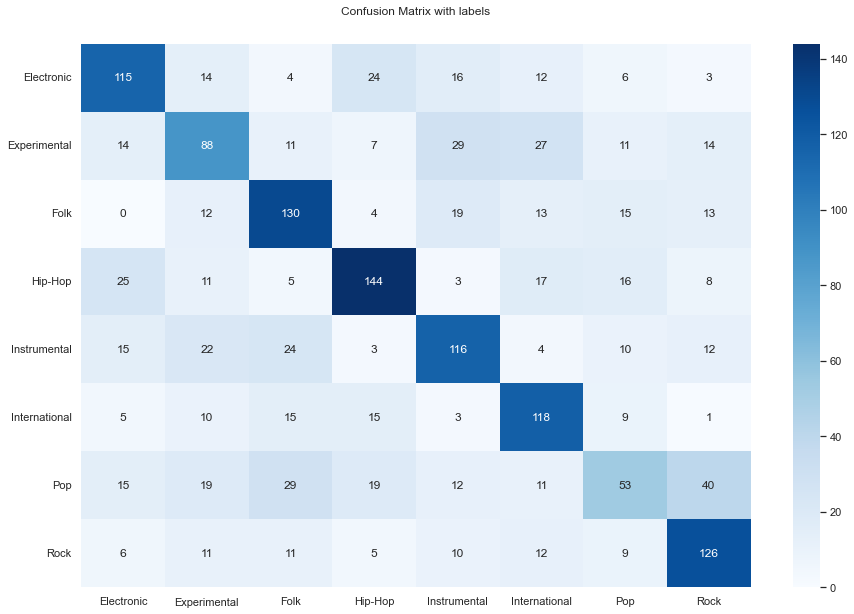

In [12]:
param_grid = {
    'penalty': ['l1', 'l2'],  
    'loss': ['hinge', 'squared_hinge'], 
    'dual': [True, False],
    'C': [1, 10, 100]
    }

grid = GridSearchCV(svm.LinearSVC(), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

grid_pred = grid.predict(X_test)

displayResults(grid, grid_pred)